In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import pickle
import os
from zipfile import ZipFile
%matplotlib inline
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
path = '/tmp/'
traffic_signs_file = 'traffic-signs-data.zip'

## Load Data

In [4]:
!wget --no-check-certificate \
    https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip \
    -O /tmp/traffic-signs-data.zip

with ZipFile(path+traffic_signs_file, 'r') as zipObj:
   zipObj.extractall(path)
   print('Finish extracting')

--2020-09-22 12:26:01--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.8
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘/tmp/traffic-signs-data.zip’

/tmp/traffic-signs- 100%[===================>] 117.80M  20.4MB/s    in 6.7s    

2020-09-22 12:26:08 (17.6 MB/s) - ‘/tmp/traffic-signs-data.zip’ saved [123524425/123524425]

Finish extracting


In [5]:
train = pickle.load(open(path+"train.p", 'rb'))
valid=pickle.load(open(path+"valid.p", 'rb'))
test = pickle.load(open(path+"test.p", 'rb'))

In [6]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Data description

In [7]:
# Verify that the data is complete
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))
# Data Size
print('Training set samples',len(X_train))
print('Validation set samples',len(X_valid))
print('Test set samples',len(X_test))

Training set samples 34799
Validation set samples 4410
Test set samples 12630


In [8]:
# Sign names labels
sign_names = pd.read_csv('signnames.csv')
sign_names.head()
sign_names.describe()

,ClassId
count,43.000000
mean,21.000000
std,12.556539
min,0.000000
25%,10.500000
50%,21.000000
75%,31.500000
max,42.000000


## Data distribution

                  0
count  12630.000000
mean      15.551069
std       11.947123
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000


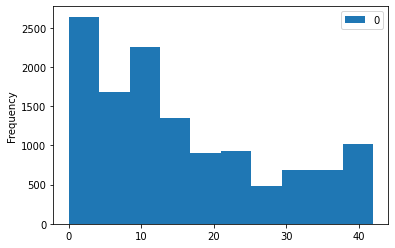

In [9]:
# Describe test Y data
df_y_test = pd.DataFrame(y_test)
print(df_y_test.describe())
df_y_test.plot.hist()

## Data Random Samples

In [ ]:
# Random signs from the Y data
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i in results[:10]:
    sign_index = y_train[i]
    print(i,sign_index,sign_names.at[sign_index,'SignName'])

In [ ]:
# Random signs images and the correspondent name
fig, axes = plt.subplots(5,5, figsize=(15,15))
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i,ax in  enumerate(axes.flat):
    pos = results[i]
    sign_index = y_train[pos]
    ax.set_title(sign_names.at[sign_index,'SignName'],fontsize=10)
    ax.imshow(X_train[pos])
    ax.set_axis_off()

## Data preprocessing

In [10]:
from sklearn.utils import shuffle
X_train = np.sum(X_train/3, axis=3, keepdims=True)[:100,]
X_valid = np.sum(X_valid/3, axis=3, keepdims=True)[:100,]
X_train, y_train = shuffle(X_train, y_train[:100])

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
def LeNet(x):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #print(conv1.shape)
    # Flatten last convolution
    fc0   = flatten(conv1)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1176, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 42), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(42))
    print(fc1.shape,fc2_W.shape,fc2_b.shape)
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 42)
rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 6)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 120) (120, 42) (42,)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
BATCH_SIZE=128
EPOCHS=10
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid, y_valid[:100,])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.000

EPOCH 2 ...
Validation Accuracy = 0.300

EPOCH 3 ...
Validation Accuracy = 0.300

EPOCH 4 ...
Validation Accuracy = 0.300

EPOCH 5 ...
Validation Accuracy = 0.300

EPOCH 6 ...
Validation Accuracy = 0.300

EPOCH 7 ...
Validation Accuracy = 0.300

EPOCH 8 ...
Validation Accuracy = 0.300

EPOCH 9 ...
Validation Accuracy = 0.300

EPOCH 10 ...
Validation Accuracy = 0.300

Model saved
